In [4]:
import cv2
import numpy as np
from skimage.filters import sobel
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [5]:
def dark_channel_prior(image, window_size=15):
    """Calculate the Dark Channel Prior."""
    min_channel = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size))
    dark_channel = cv2.erode(min_channel, kernel)
    return dark_channel

def atmospheric_light(image, dark_channel, top_percent=0.001):
    """Estimate atmospheric light from the image."""
    flat_image = image.reshape(-1, 3)
    flat_dark = dark_channel.ravel()
    num_pixels = int(top_percent * len(flat_dark))
    indices = flat_dark.argsort()[-num_pixels:]
    atm_light = flat_image[indices].mean(axis=0)
    return atm_light

def dehaze(image, omega=0.95, t_min=0.1):
    """Dehaze the image using the Dark Channel Prior."""
    dark_channel = dark_channel_prior(image)
    atm_light = atmospheric_light(image, dark_channel)
    transmission = 1 - omega * dark_channel / 255.0
    transmission = np.clip(transmission, t_min, 1)
    recovered = (image - atm_light) / transmission[:, :, None] + atm_light
    return np.clip(recovered, 0, 255).astype('uint8')

def saliency_map(image):
    """Compute the Saliency Map using Sobel edge detection."""
    gray = rgb2gray(image)
    edges = sobel(gray)
    return edges

def merge_contours(contours, distance_threshold=50, min_width=50, min_height=30):
    """Merge nearby contours into a single bounding box and ensure tight dimensions."""
    merged_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > min_width and h > min_height:  
            new_box = [x, y, x + w, y + h]
            merged = False
            for i, box in enumerate(merged_boxes):
                if not (new_box[2] < box[0] or new_box[0] > box[2] or new_box[3] < box[1] or new_box[1] > box[3]):
                    merged_boxes[i] = [
                        min(box[0], new_box[0]),
                        min(box[1], new_box[1]),
                        max(box[2], new_box[2]),
                        max(box[3], new_box[3])
                    ]
                    merged = True
                    break
            if not merged:
                merged_boxes.append(new_box)
    return merged_boxes

def detect_vehicles(image, saliency, min_contour_area=150):
    """Detect vehicles using saliency and morphological operations with contour merging."""
    _, thresh = cv2.threshold((saliency * 255).astype('uint8'), 20, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    merged_boxes = merge_contours(contours)
    detected_image = image.copy()
    for box in merged_boxes:
        x1, y1, x2, y2 = box
        if (x2 - x1) * (y2 - y1) > min_contour_area:
            cv2.rectangle(detected_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return detected_image


In [6]:
image_path = "image9.jpg"  
foggy_image = cv2.imread(image_path)
foggy_image = cv2.cvtColor(foggy_image, cv2.COLOR_BGR2RGB)

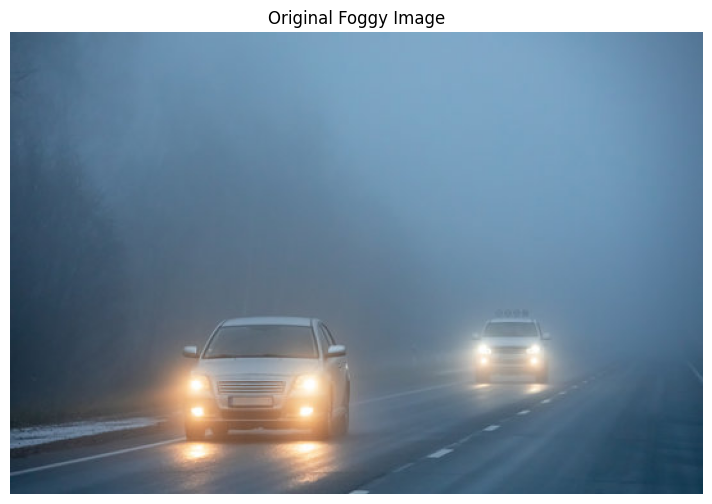

In [7]:
plt.figure(figsize=(10, 6))
plt.imshow(foggy_image)
plt.title("Original Foggy Image")
plt.axis("off")
plt.show()

In [8]:
recovered_image = dehaze(foggy_image)

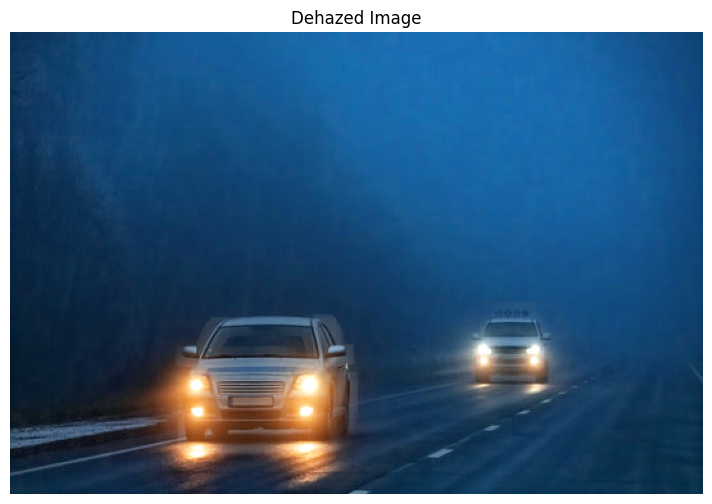

In [9]:
plt.figure(figsize=(10, 6))
plt.imshow(recovered_image)
plt.title("Dehazed Image")
plt.axis("off")
plt.show()

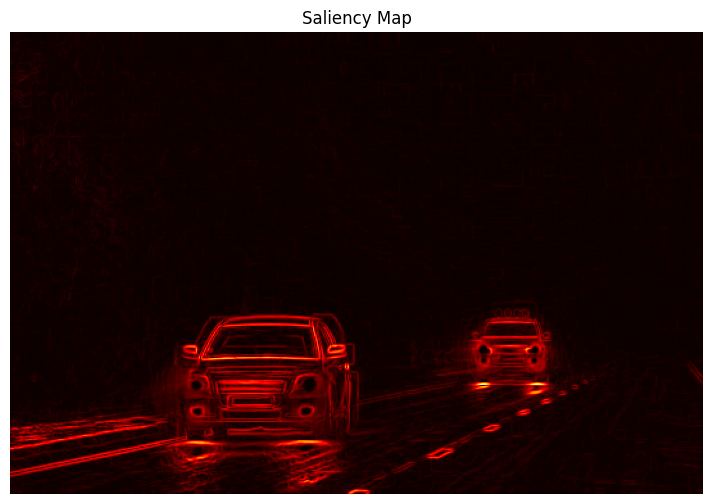

In [11]:
saliency = saliency_map(recovered_image)
plt.figure(figsize=(10, 6))
plt.imshow(saliency, cmap="hot")
plt.title("Saliency Map")
plt.axis("off")
plt.show()

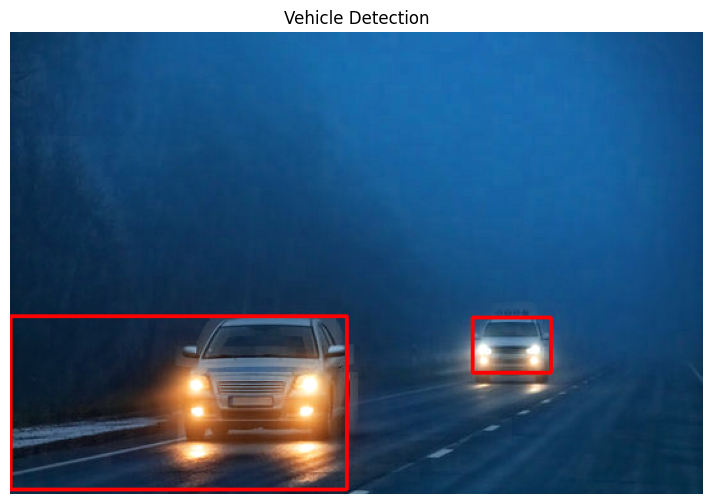

In [12]:
detected_image = detect_vehicles(recovered_image, saliency)
plt.figure(figsize=(10, 6))
plt.imshow(detected_image)
plt.title("Vehicle Detection")
plt.axis("off")
plt.show()

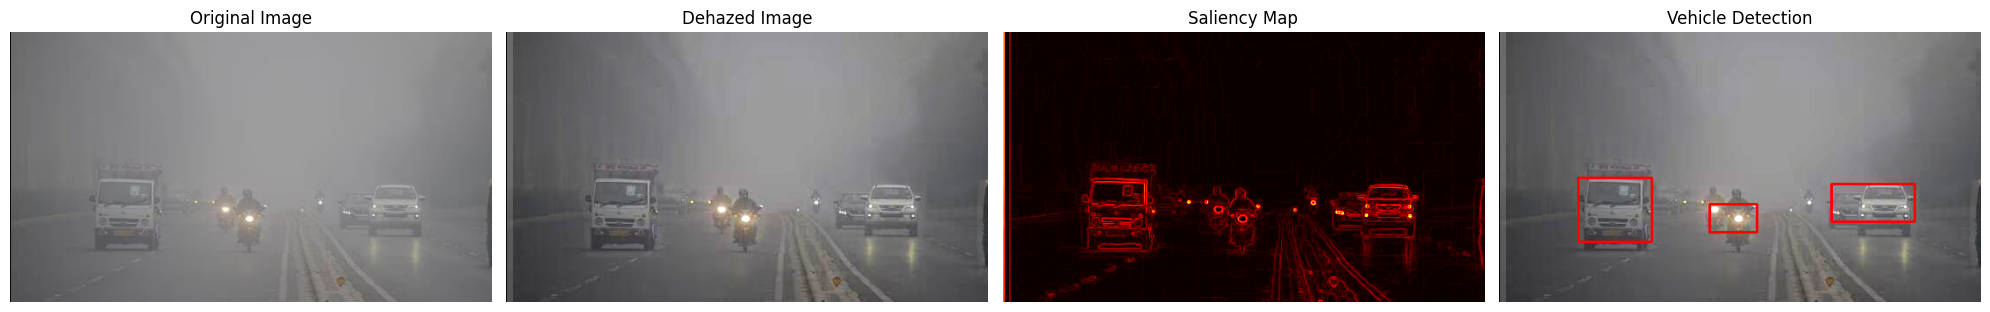

In [13]:
def process_new_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dehazed_image = dehaze(image)
    saliency = saliency_map(dehazed_image)
    detected_image = detect_vehicles(dehazed_image, saliency)
    return image, dehazed_image, saliency, detected_image

new_image_path = "image4.jpg" 
orig_new, de_new, sa_new, det_new = process_new_image(new_image_path)

plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(orig_new)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(de_new)
plt.title("Dehazed Image")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(sa_new, cmap="hot")
plt.title("Saliency Map")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(det_new)
plt.title("Vehicle Detection")
plt.axis("off")

plt.tight_layout()
plt.show()
